In [1]:
import numpy as np
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import gensim

In [27]:
import pandas as pd
import time
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
ps = PorterStemmer()
import re
from sklearn.decomposition import PCA

# Tokenize Words

In [3]:
df_file = pd.read_csv('NYTimes_2000.csv') 
sen_list = []

# timer
start = time.time()
for i, row in df_file.iterrows():
    #['id', 'url', 'headline', 'abstract'] 
    
    sen = str(row['headline'])
    sen = re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', sen)
    for s in sen:
        stem_w = []
        s_p = ''.join(w for w in s if w not in punctuation)
        token = word_tokenize(s_p)

        # filter numbers, 移除 4碼年份以外的 word
        for w in token:
            try:
                if str(int(float(w))).isnumeric() and len(w) != 4:
                    token.remove(w)
            except:
                pass

        for w in token:
            stem_w.append(ps.stem(w))

        # print('stem_w:', stem_w)
        s = " ".join(stem_w)
        sen_list.append(s)
        
    sen = str(row['abstract'])  
    sen = re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', sen)
    for s in sen:
        stem_w = []
        s_p = ''.join(w for w in s if w not in punctuation)
        token = word_tokenize(s_p)
        
        # filter numbers,移除 4碼年份以外的 word
        for w in token:
            try:
                if str(int(float(w))).isnumeric() and len(w) != 4:
                    token.remove(w)
            except:
                pass

        for w in token:
            stem_w.append(ps.stem(w))

        # print('stem_w:', stem_w)
        s = " ".join(stem_w)
        sen_list.append(s)

end = time.time()
print('time:',end - start)

# timer
start = time.time()
token = Tokenizer() 
token.fit_on_texts(sen_list) 
seq = token.texts_to_sequences(sen_list)
print('after seq:', seq)
total_word = sum(len(w) for w in seq) # sum of words
print('total_word:', total_word)
word_count = len(token.word_index) # sum of distinct words
print('word_count:', word_count)
window_size = 2

end = time.time()
print('time:',end - start)

time: 1.6785972118377686
after seq: [[910, 195, 62, 13, 586, 3, 388, 52], [479, 13, 21, 779, 5, 36, 94, 13, 226, 23, 93, 303, 587, 62, 13, 389, 3, 1, 1333, 654, 37, 49, 1334, 3, 216, 2573], [2574, 75, 1, 72, 341, 1, 588, 4, 839], [2575, 227, 4, 1, 24, 27, 162, 1749, 208, 2, 158, 3, 10, 1, 911, 6, 122, 1191], [408, 220, 112, 780, 1, 47, 7, 8, 69, 995, 36, 80, 94], [2, 996, 589, 36, 80, 69, 995, 6, 217, 26, 58, 997, 6, 408, 220, 112, 56, 11, 424], [1, 781, 912, 317, 14, 409, 16, 2, 1335, 36, 226], [781, 912, 840, 734, 6, 1, 2576, 4, 2, 554, 226, 6, 36, 94, 38, 2577, 10, 5, 998, 14, 25, 409, 16, 2, 1074, 15, 1335, 735], [1750, 7, 8, 4486, 367, 1751, 38, 2, 1192, 6, 1, 782], [2, 1550, 367, 6, 1750, 7, 8, 1193, 26, 1751, 38, 221, 6, 1, 782, 17, 272, 4, 230, 7, 8, 95, 841, 2578, 131, 25, 694, 3, 216, 61], [230, 22, 128, 1551, 162, 173, 222, 3, 104, 529, 218, 425, 5, 113, 410, 15, 178, 1, 72], [230, 22, 128, 222, 480, 3, 425, 162, 76, 81, 1, 39, 3, 149, 48, 82, 1075, 4, 2, 529, 36, 104, 6, 25

# Define Model

In [4]:
# to transform a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest sequence in the list.
# Converts a class vector (integers) to binary class matrix.
def cbow_model(seq, window_size, total_word):
    total_length = window_size*2
    # print(total_length)
    for text in seq:
        text_len = len(text)
        for idx, word in enumerate(text):
            context_word = []
            target   = []            
            begin = idx - window_size
            end = idx + window_size + 1
            context_word.append([text[i] for i in range(begin, end) if 0 <= i < text_len and i != idx])
            target.append(word)
            # print('context_word:', context_word, '\ntarget:', target)
            contextual = sequence.pad_sequences(context_word, maxlen=total_length)
            # print('contextual:', contextual)
            final_target = np_utils.to_categorical(target, total_word)
            # print('final_target:', final_target)
            yield(contextual, final_target)

In [5]:
cbow_model(seq, window_size, total_word)

<generator object cbow_model at 0x000001B423583D60>

In [6]:
# Sequential groups a linear stack of layers into a tf.keras.Model.
# class Dense: Just your regular densely-connected NN layer.
# class Embedding: Turns positive integers (indexes) into dense vectors of fixed size.
# class Lambda: Wraps arbitrary expressions as a Layer object.
# compile: Configures the model for training.
# train_on_batch: Runs a single gradient update on a single batch of data.
# keras.backend.mean: Mean of a tensor, alongside the specified axis.
def train_model(seq, total_word, window_size, epoch):
    model = Sequential()
    model.add(Embedding(input_dim=total_word, output_dim=100, input_length=window_size*2))
    model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(100,)))
    model.add(Dense(total_word, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    for i in range(epoch):
        # timer
        start = time.time()
        loss = 0
        for x, y in cbow_model(seq, window_size, total_word):
            loss += model.train_on_batch(x, y)
        print(i, loss)
        
        end = time.time()
        print('epoch:', i, 'takes time:', end - start)
        
    # pickle.dump(model, open('win01_model.sav', 'wb'))
    return model

In [7]:
model = train_model(seq, total_word, window_size, 8)

0 509715.7837074073
epoch: 0 takes time: 3256.7586550712585
1 439520.9163339179
epoch: 1 takes time: 3254.8105235099792
2 375399.729639198
epoch: 2 takes time: 3257.1169300079346
3 330336.87194691185
epoch: 3 takes time: 3258.789302587509
4 298567.8329297057
epoch: 4 takes time: 3258.2015714645386
5 276208.48567259405
epoch: 5 takes time: 3256.5974695682526
6 259799.81442686674
epoch: 6 takes time: 3257.76615858078
7 247800.75867084155
epoch: 7 takes time: 3276.505479335785


In [54]:
# pickle.dump(model, open('win01_model.sav', 'wb'))
model.save('win01_model.bin')

INFO:tensorflow:Assets written to: win01_model.bin\assets


# Get Text, Weight List

In [114]:
# weights[32, :]
# weights = model.get_weights()[0]
# print(weights[0])
# print(weights)
# print(token.word_index.keys())

weights = model.get_weights()[0]
list_sw = stopwords.words('english')
list_sw = list_sw + ['’','—', '“', '”', '‘']

list_ind = []
list_text = []
list_weight = []

for text, i in token.word_index.items():
    
    if text in list_sw:
        # print('remove', i, text)
        # pass
        continue
    
    
    list_ind.append((i,text))
    list_text.append(text)
    list_weight.append((weights[i]))
        
list_weight = np.array(list_weight)


In [115]:
print(list_weight)
# print(list_text)
# print(list_ind)

[[ 0.99301594 -0.50430644 -0.94072014 ... -0.11920942 -0.9763257
  -0.52911675]
 [ 0.08939363  0.13017288 -1.8357573  ... -0.33898094  0.01505792
  -1.0708154 ]
 [ 0.3872156  -0.22888017  0.0365049  ...  0.0257222  -1.1609007
   0.5534391 ]
 ...
 [-0.3308818  -0.05137473 -0.3125301  ... -0.20496503 -0.17770551
   0.03094128]
 [-0.32075834  0.08732741 -0.2699532  ...  0.2939537  -0.39093733
  -0.02677163]
 [-0.05373723  0.27550888 -0.30617806 ... -0.05938096  0.05254952
   0.29011658]]


In [116]:
df_collect = pd.DataFrame(columns = ['word', 'weight'])
df_collect.loc[len(df_collect)] = [list_text, list_weight]
df_collect.to_csv('win01_collect.csv', index=False)
df_get = pd.read_csv('win01_collect.csv') 
for i, row in df_get.iterrows():
    words = row['word']
    weight = row['weight']

# print(words,'\n', weight)
print(type(list(words)),'\n', type(np.array(weight)))
# print(words,'\n', weight)

<class 'list'> 
 <class 'numpy.ndarray'>


# Visualize after PCA

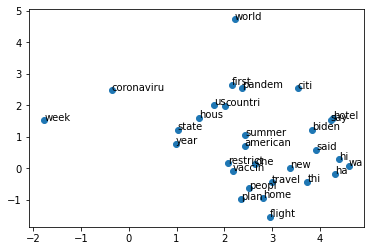

In [117]:
# fit a 2d PCA model to the vectors
pca = PCA(n_components=2)
result = pca.fit_transform(list_weight)

# create a scatter plot of the projection

plt.scatter(result[:30, 0], result[:30, 1])
words = list(list_text)
for i, word in enumerate(list_text[:30]):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

C:\Users\ftstc\AppData\Local\Temp/ipykernel_21100/2494165178.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


['travel', 'new', 'vaccin', 'pandem', 'ha', 'thi', 'year', 'wa', 'coronaviru', 'countri', 'us', 'week', 'state', 'citi', 'peopl', 'summer', 'said', 'hi', 'plan', 'home', 'american', 'restrict', 'biden', 'one', 'first', 'world', 'say', 'hotel', 'flight', 'hous', 'time', 'variant', 'airlin', 'get', 'like', 'presid', 'york', 'could', 'may', 'day', 'mani', 'case', 'covid', 'back', 'look', 'still', 'tourist', 'make', 'thing', 'even', 'test', 'trip', 'unit', 'return', 'offici', 'reopen', 'place', 'come', 'last', 'nation', 'know', 'open', 'recommend', 'european', 'need', 'visitor', 'requir', 'famili', 'start', 'border', 'take', 'list', 'million', 'go', 'would', 'industri', 'busi', 'viru', 'ban', 'hope', 'move', 'tourism', 'space', 'show', 'two', 'quarantin', 'monday', 'work', 'five', 'way', 'life', 'hunt', 'face', 'intern', 'end', 'chang', 'covid19', 'compani', 'month', 'allow']


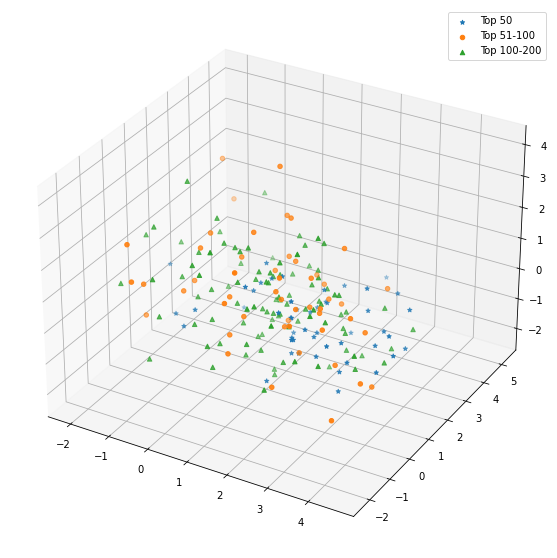

In [142]:
# fit a 3d PCA model to the vectors
pca = PCA(n_components=3)
result = pca.fit_transform(list_weight)

# create a scatter plot of the projection
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')


# 繪製 3D 座標點
ax.scatter(result[:50, 0], result[:50, 1], result[:50, 2], cmap='Reds', marker='*', label='Top 50')
ax.scatter(result[50:100, 0], result[50:100, 1], result[50:100, 2], cmap='Blues', marker='o', label='Top 51-100')
ax.scatter(result[100:200, 0], result[100:200, 1], result[100:200, 2], cmap='Greens', marker='^', label='Top 100-200')

# 顯示圖例
ax.legend(loc='best', bbox_to_anchor=(1, 0, 0, 1))

print(list_text[0:100])
# 顯示圖形
plt.show()


In [219]:
df_3d = pd.DataFrame(columns = ['word', '3d'])
for i, r in enumerate(result):
    df_3d.loc[len(df_3d)] = [list_text[i], r]

print(df_3d.tail())

            word                                       3d
5257  unrecogniz   [-0.8261251, -0.33578137, -0.69179976]
5258    kandahar   [-0.86761916, -0.15749371, 0.08871539]
5259    warehous    [-0.5182906, -0.19800843, -0.5395372]
5260       begun  [-0.54930645, -0.28570983, -0.51388323]
5261   benchmark   [-0.71123254, -0.19154732, 0.12496237]


# Save in CSV File

In [218]:
list_col = ['word'] + ['weight'] + list(range(1, 101))
df_array = pd.DataFrame(columns = list_col)
weights = model.get_weights()[0]
list_sw = stopwords.words('english')
list_sw = list_sw + ['’','—', '“', '”', '‘']

for text, i in token.word_index.items():
    list_temp = []
    if text in list_sw:
        # print('remove', i, text)
        # pass
        continue
        
    list_temp.append(text)   
    list_temp.append(weights[i])
    
    for v in weights[i, :]:
        list_temp.append(v)
        
    # print(text, i, weights[i], list_temp)    
    df_array.loc[len(df_array)] = list_temp

In [202]:
print(len(df_array),'\n', df_array.tail())

5262 
             word                                             weight         1  \
5257  unrecogniz  [0.18900636, -0.0119787175, 0.004438102, 0.255...  0.189006   
5258    kandahar  [-0.32940072, 0.22686061, -0.15186042, -0.0411... -0.329401   
5259    warehous  [-0.3308818, -0.051374733, -0.3125301, 0.06574... -0.330882   
5260       begun  [-0.32075834, 0.087327406, -0.2699532, -0.2065... -0.320758   
5261   benchmark  [-0.05373723, 0.27550888, -0.30617806, -0.1014... -0.053737   

             2         3         4         5         6         7         8  \
5257 -0.011979  0.004438  0.255953 -0.092404 -0.270381  0.007672  0.210690   
5258  0.226861 -0.151860 -0.041151  0.303697 -0.063946 -0.229275  0.024937   
5259 -0.051375 -0.312530  0.065741  0.095822 -0.040770 -0.206068  0.161573   
5260  0.087327 -0.269953 -0.206589 -0.033705  0.229930  0.287841  0.144551   
5261  0.275509 -0.306178 -0.101419  0.360774 -0.038818 -0.017596 -0.145365   

      ...        91        92        

In [157]:
df_array.to_csv('win01_array.csv', index=False)

# Save Vectors to TXT

In [203]:
dimensions=100
vect_file_100 = open('100d_vectors.txt' ,'w')
vect_file_100.write('{} {}\n'.format(len(list_text), dimensions))
vect_file_3 = open('3d_vectors.txt' ,'w')
vect_file_3.write('{} {}\n'.format(len(list_text), 3))

7

In [204]:
weights = model.get_weights()[0]
for i, word in enumerate(list_text):
    
    final_vec_100 = ' '.join(map(str, list(list_weight[i, :])))
    vect_file_100.write('{} {}\n'.format(word, final_vec_100))

for i, word in enumerate(list_text):

    final_vec_3 = ' '.join(map(str, list(result[i, :])))
    vect_file_3.write('{} {}\n'.format(word, final_vec_3))
    
vect_file_100.close()
vect_file_3.close()

In [205]:
cbow_output_100 = gensim.models.KeyedVectors.load_word2vec_format('100d_vectors.txt', binary=False, encoding='unicode_escape')
cbow_output_3 = gensim.models.KeyedVectors.load_word2vec_format('3d_vectors.txt', binary=False, encoding='unicode_escape')

In [235]:
def find_similar_100(query):
    r = cbow_output_100.most_similar(positive=[query])
    print(query,'(100):\n', r)
    return r
def find_similar_3(query):
    r = cbow_output_3.most_similar(positive=[query])
    print(query,'(3):\n', r)
    return r

travel (100):
 [('recumb', 0.5448194742202759), ('wildfir', 0.5097671151161194), ('jewelri', 0.49767839908599854), ('robert', 0.4912112355232239), ('jame', 0.49105891585350037), ('siya', 0.49086254835128784), ('would', 0.48427292704582214), ('cellphon', 0.4841245114803314), ('safeti', 0.484068900346756), ('sister', 0.4835134744644165)]
travel (3):
 [('turkish', 0.9999654293060303), ('parti', 0.9999138712882996), ('inlet', 0.9998117089271545), ('dr', 0.9998078346252441), ('cox', 0.9997904896736145), ('roosevelt', 0.9997307062149048), ('ray', 0.9997156858444214), ('hospit', 0.9995862245559692), ('nieci', 0.9994781613349915), ('recumb', 0.9994679689407349)]


C:\Users\ftstc\AppData\Local\Temp/ipykernel_21100/365691954.py:8: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


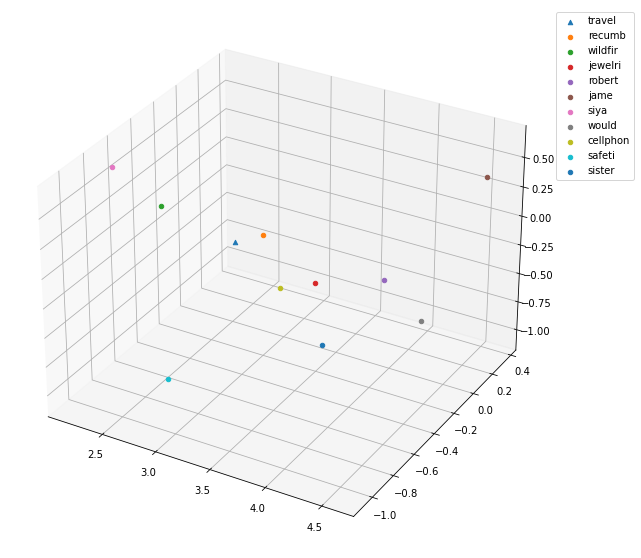

C:\Users\ftstc\AppData\Local\Temp/ipykernel_21100/365691954.py:22: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


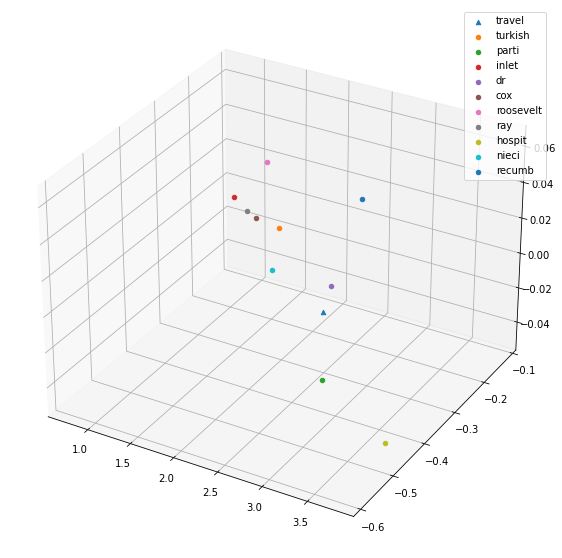



new (100):
 [('wildfir', 0.5356491208076477), ('yayoi', 0.5029609799385071), ('lui', 0.5013666152954102), ('reed', 0.4920283555984497), ('eerili', 0.485465943813324), ('hauser', 0.4848340153694153), ('gener', 0.48360198736190796), ('recumb', 0.4834142327308655), ('handpul', 0.48249566555023193), ('santa', 0.4812716841697693)]
new (3):
 [('failur', 0.999843418598175), ('wa', 0.9997142553329468), ('experi', 0.9992228746414185), ('sentinel', 0.9990351796150208), ('separatist', 0.9990010261535645), ('boom', 0.9988450407981873), ('guest', 0.9988279938697815), ('adjut', 0.9987692832946777), ('one', 0.998714804649353), ('drug', 0.9985406994819641)]


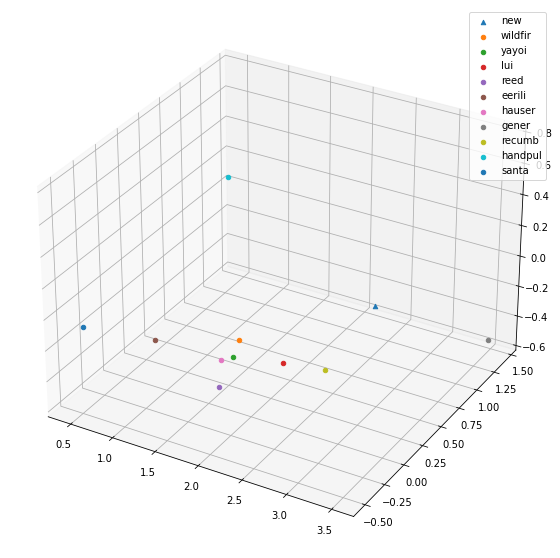

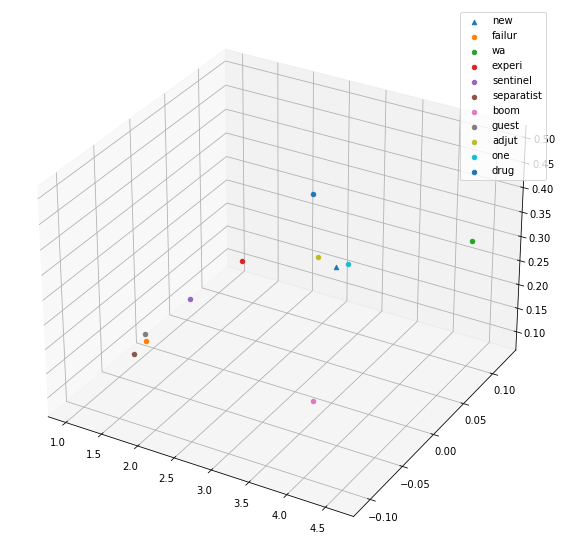



vaccin (100):
 [('without', 0.48763158917427063), ('electron', 0.48412251472473145), ('yayoi', 0.44675278663635254), ('north', 0.4463057219982147), ('warn', 0.44512414932250977), ('toughmind', 0.4300045967102051), ('program', 0.42994919419288635), ('mohammad', 0.4230869710445404), ('recumb', 0.4201792776584625), ('crisi', 0.41809362173080444)]
vaccin (3):
 [('hallway', 0.9998694658279419), ('book', 0.9997403025627136), ('beauxart', 0.9997158646583557), ('bought', 0.9995743632316589), ('spring', 0.9994611740112305), ('shack', 0.9993972778320312), ('reson', 0.9992491006851196), ('trip', 0.998990535736084), ('belaru', 0.9986991882324219), ('club', 0.9985482692718506)]


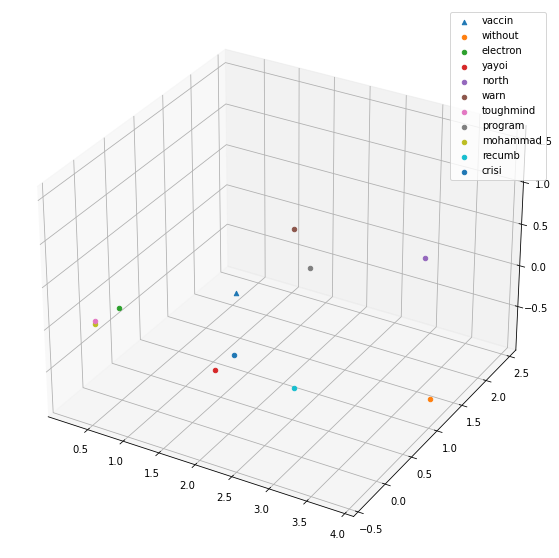

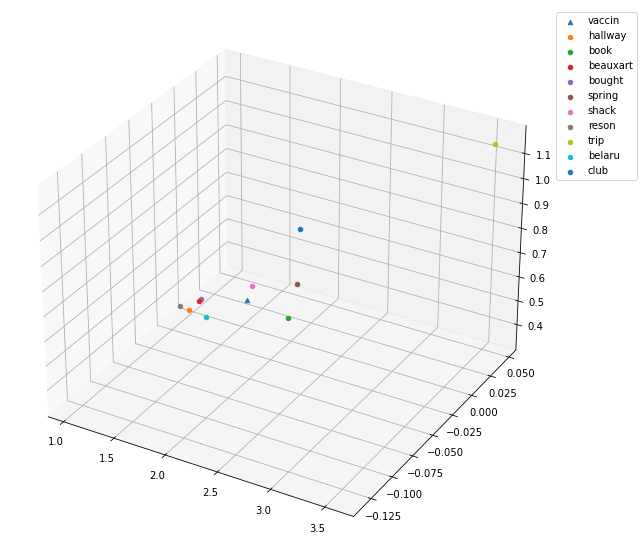



pandem (100):
 [('furnitur', 0.4943995475769043), ('taj', 0.4843440055847168), ('internet', 0.47919225692749023), ('senat', 0.47695353627204895), ('festiv', 0.4694322347640991), ('longlost', 0.46529921889305115), ('olymp', 0.4634934663772583), ('ballard', 0.4578908085823059), ('cdc', 0.45788711309432983), ('coast', 0.4551851153373718)]
pandem (3):
 [('night', 0.9997245669364929), ('subway', 0.9993264675140381), ('jan', 0.9989400506019592), ('street', 0.9988117814064026), ('whi', 0.9985741972923279), ('entrepreneur', 0.9980052709579468), ('presid', 0.9954239130020142), ('longlost', 0.9951465725898743), ('taj', 0.995089054107666), ('jadhav', 0.994855523109436)]


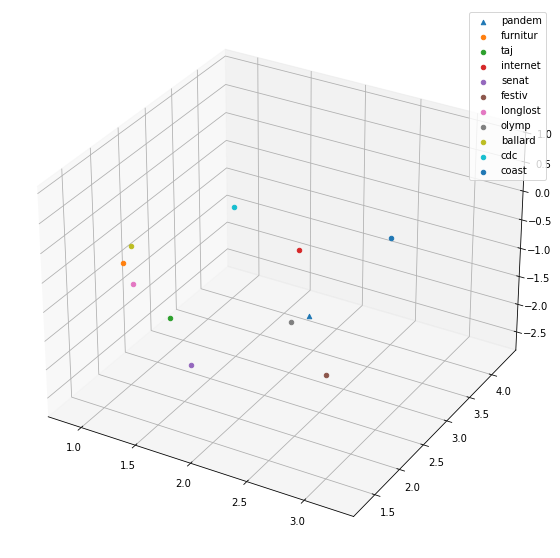

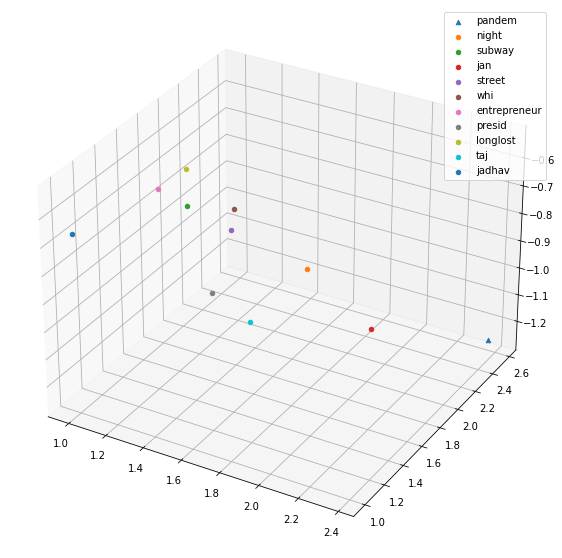



ha (100):
 [('sri', 0.6125630140304565), ('tradit', 0.5728166103363037), ('newsom', 0.5637679696083069), ('coral', 0.5629879236221313), ('yayoi', 0.5563257932662964), ('sonia', 0.5550572872161865), ('lopez', 0.5485744476318359), ('would', 0.5436182022094727), ('birthday', 0.541020393371582), ('cellphon', 0.537824809551239)]
ha (3):
 [('nearli', 0.9999963641166687), ('ashleigh', 0.9999956488609314), ('il', 0.9999498724937439), ('riad', 0.999883770942688), ('song', 0.9996271729469299), ('dessert', 0.9994394183158875), ('crab', 0.9994311332702637), ('quieter', 0.9994111657142639), ('canal', 0.9993591904640198), ('revenu', 0.9989761114120483)]


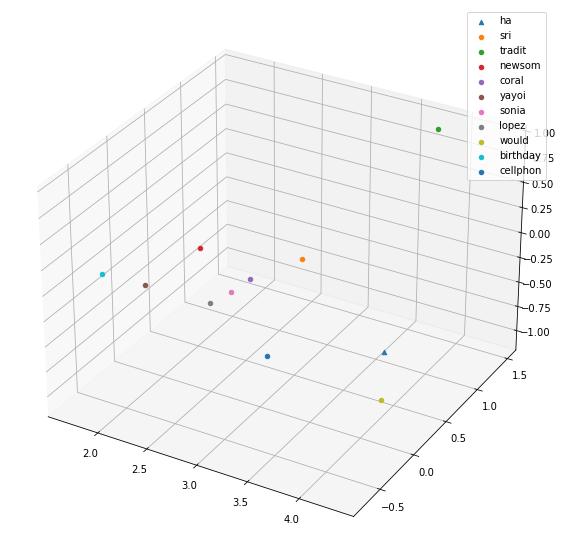

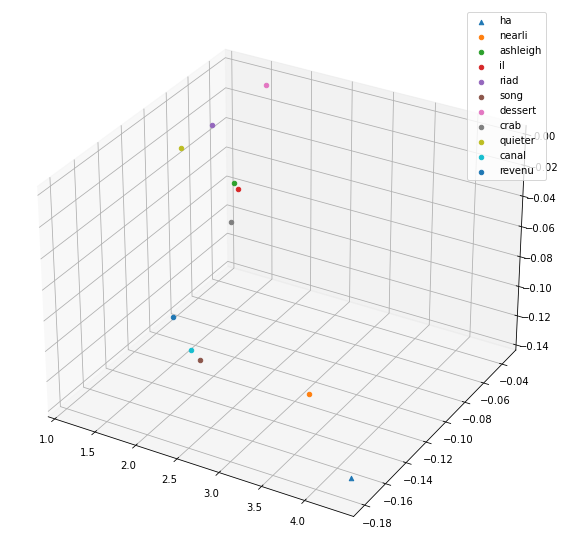



thi (100):
 [('video', 0.5933085083961487), ('pioneer', 0.556761622428894), ('sri', 0.5567394495010376), ('scant', 0.5565083622932434), ('adjut', 0.5442384481430054), ('dessert', 0.5434238910675049), ('seven', 0.5385069847106934), ('sonia', 0.5379689335823059), ('recumb', 0.5318118333816528), ('isaacman', 0.5242384672164917)]
thi (3):
 [('green', 0.9999752640724182), ('recumb', 0.9999661445617676), ('charlott', 0.9998971819877625), ('robert', 0.9998667240142822), ('roosevelt', 0.999788761138916), ('inform', 0.9996679425239563), ('abroad', 0.9995176196098328), ('mobil', 0.9995128512382507), ('argu', 0.9994039535522461), ('emphas', 0.9993451833724976)]


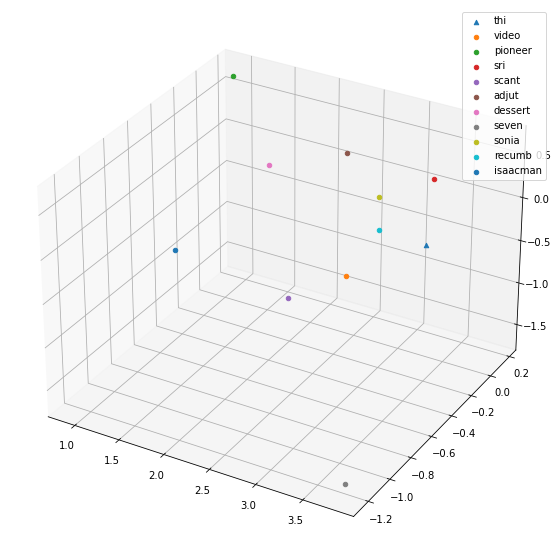

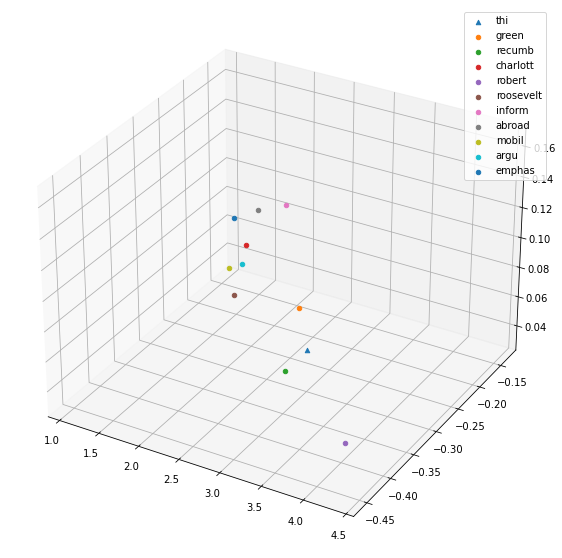



year (100):
 [('benjamin', 0.4564981162548065), ('water', 0.4244133234024048), ('ardern', 0.3944823741912842), ('la', 0.38360846042633057), ('lawn', 0.3821561932563782), ('basebal', 0.37747570872306824), ('reflect', 0.3729517459869385), ('practic', 0.37262463569641113), ('month', 0.3681662380695343), ('tenni', 0.35914966464042664)]
year (3):
 [('second', 0.9997584819793701), ('soccer', 0.9993891716003418), ('indigen', 0.9986439943313599), ('danger', 0.9979416131973267), ('put', 0.9958444833755493), ('portrait', 0.994926929473877), ('group', 0.9943447113037109), ('recommend', 0.9942742586135864), ('revers', 0.9929341673851013), ('surg', 0.9925646781921387)]


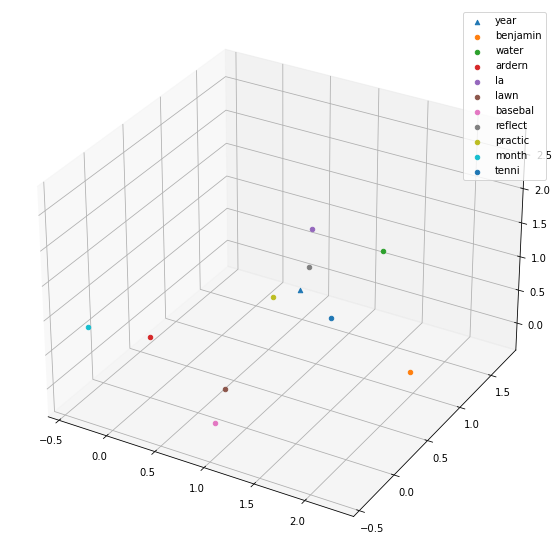

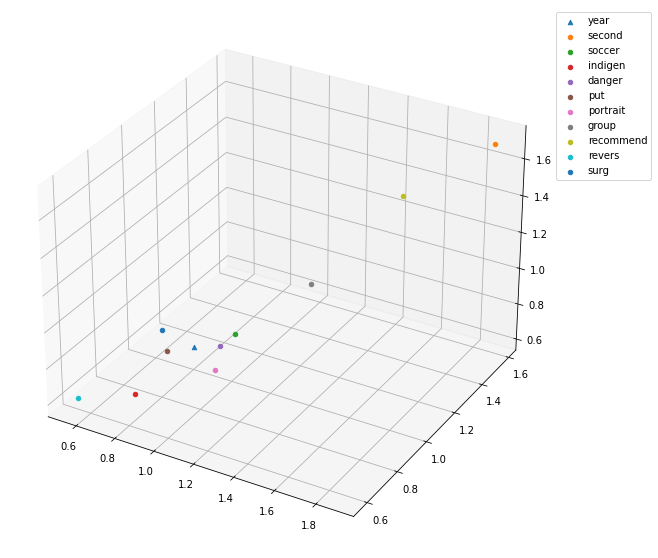



wa (100):
 [('robert', 0.632198691368103), ('dick', 0.6153184175491333), ('fish', 0.5965011715888977), ('pont', 0.5894570350646973), ('relentlessli', 0.5834765434265137), ('dude', 0.5821919441223145), ('betray', 0.5766394734382629), ('sri', 0.5744034051895142), ('salvador', 0.5700006484985352), ('lauri', 0.5696826577186584)]
wa (3):
 [('new', 0.9997142553329468), ('one', 0.9995754957199097), ('adjut', 0.9994568824768066), ('failur', 0.9993985891342163), ('plu', 0.9993091225624084), ('sentinel', 0.9991432428359985), ('jame', 0.9990097284317017), ('boom', 0.9988383054733276), ('lover', 0.9987702965736389), ('alway', 0.9986007213592529)]


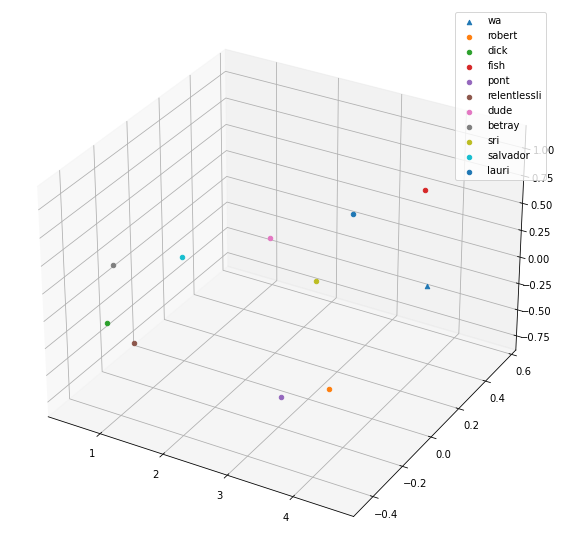

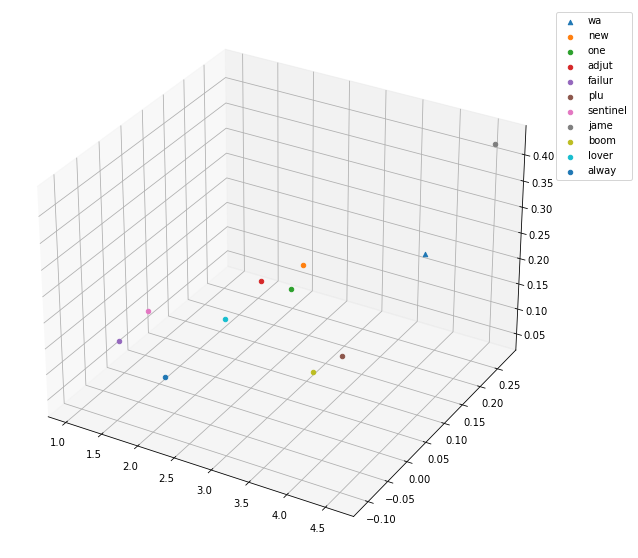



coronaviru (100):
 [('brazilian', 0.44134411215782166), ('viru', 0.43894678354263306), ('spell', 0.43358078598976135), ('mediterranean', 0.4207269549369812), ('east', 0.40491968393325806), ('philippin', 0.4006102383136749), ('ftc', 0.39736926555633545), ('capit', 0.3972877860069275), ('process', 0.391119122505188), ('sorrow', 0.3887256383895874)]
coronaviru (3):
 [('cap', 0.9993091821670532), ('celesti', 0.997297465801239), ('pregonespuerto', 0.993425190448761), ('irish', 0.9928126335144043), ('control', 0.9927090406417847), ('leak', 0.9919694066047668), ('draft', 0.9914935827255249), ('suprem', 0.9910488128662109), ('max', 0.9909565448760986), ('metro', 0.9894393682479858)]


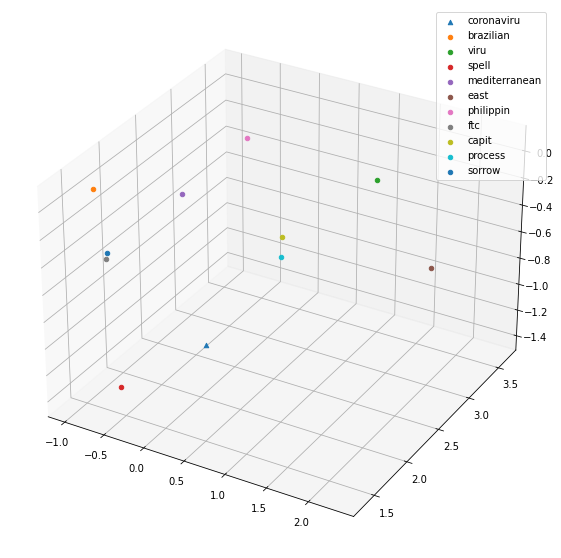

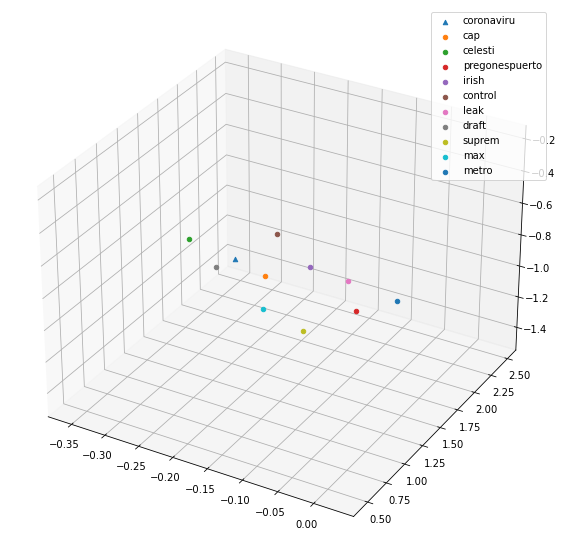



countri (100):
 [('island', 0.49507176876068115), ('airlin', 0.4941989779472351), ('eerili', 0.4619380235671997), ('ballard', 0.4590109884738922), ('contin', 0.4580596685409546), ('world', 0.45460495352745056), ('beach', 0.44815248250961304), ('arizona', 0.44058215618133545), ('senat', 0.43039992451667786), ('ocean', 0.4295251965522766)]
countri (3):
 [('headach', 0.9998238682746887), ('mediev', 0.9994418621063232), ('hidden', 0.9992374181747437), ('industri', 0.9983538389205933), ('hill', 0.9968723058700562), ('natur', 0.9968153238296509), ('weather', 0.996779203414917), ('compani', 0.9967029690742493), ('court', 0.9963241815567017), ('shift', 0.9962149262428284)]


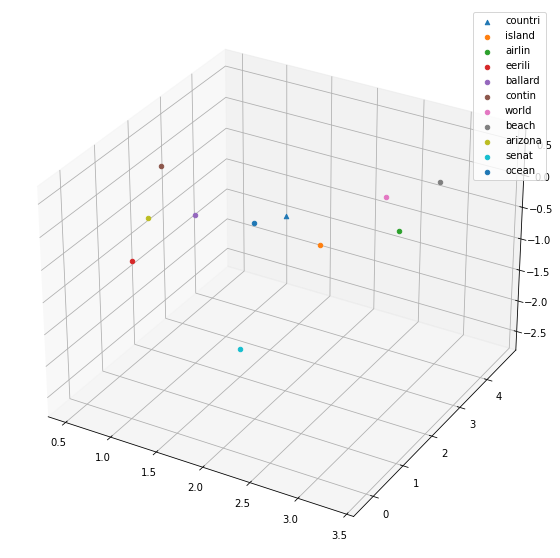

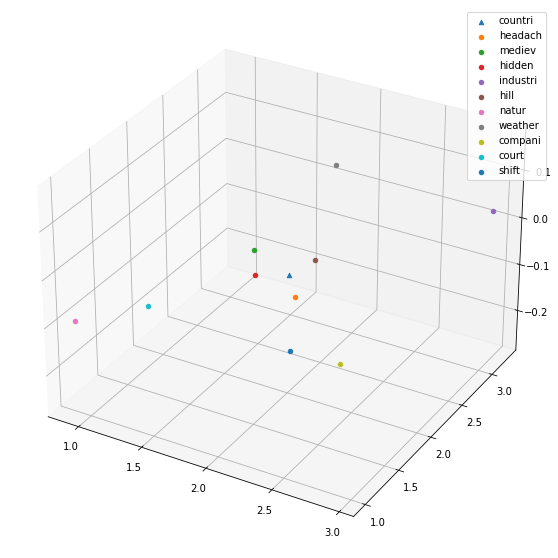

In [244]:
for t in list_text[0:10]:
    list_r100 = []
    list_r003 = []
    
    r100 = find_similar_100(t)
    r003 = find_similar_3(t)
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    sub_df = df_3d.loc[df_3d['word'] == t]
    v = sub_df.iloc[0]['3d']
    ax.scatter(v[0], v[1], v[2], cmap='Reds', marker='^', label = t)
    for r in r100:
        list_r100.append(r[0])
        sub_df = df_3d.loc[df_3d['word'] == r[0]]
        v = sub_df.iloc[0]['3d']
        ax.scatter(v[0], v[1], v[2], cmap='Reds', marker='o', label = r[0])
    
    ax.legend(loc='best', bbox_to_anchor=(1, 0, 0, 1))
    plt.show()
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    sub_df = df_3d.loc[df_3d['word'] == t]
    v = sub_df.iloc[0]['3d']
    ax.scatter(v[0], v[1], v[2], cmap='Reds', marker='^', label = t)
    for r in r003:
        list_r003.append(r[0])
        sub_df = df_3d.loc[df_3d['word'] == r[0]]
        v = sub_df.iloc[0]['3d']
        ax.scatter(v[0], v[1], v[2], cmap='Reds', marker='o', label = r[0])
    
    ax.legend(loc='best', bbox_to_anchor=(1, 0, 0, 1))
    plt.show()
        
    print('\n')